In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2


Bad key "hatch.linewidth" on line 54 in
/home/gpleiss/.dotfiles/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
from torch.autograd import Variable

n = 30
train_x = torch.zeros(int(pow(n, 2)), 2)
train_y = torch.zeros(int(pow(n, 2)))
for i in range(n):
    for j in range(n):
        train_x[i * n + j][0] = float(i) / (n - 1)
        train_x[i * n + j][1] = float(j) / (n - 1)
        train_y[i * n + j] = pow(-1, int(3 * i / n + int(3 * j / n)))
train_x = Variable(train_x)
train_y = Variable(train_y)

In [3]:
from torch import nn, optim
from gpytorch.kernels import RBFKernel, GridInterpolationKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood, BernoulliLikelihood
from gpytorch.random_variables import GaussianRandomVariable

In [4]:
class GPClassificationModel(gpytorch.models.GridInducingVariationalGP):
    def __init__(self):
        super(GPClassificationModel, self).__init__(grid_size=10, grid_bounds=[(0, 1), (0, 1)])
        self.mean_module = ConstantMean(constant_bounds=[-1e-5, 1e-5])
        self.covar_module = RBFKernel(log_lengthscale_bounds=(-5, 6))
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])), bounds=(-5,6))
        
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        covar_x = covar_x.mul(self.log_outputscale.exp())
        latent_pred = GaussianRandomVariable(mean_x, covar_x)
        return latent_pred
    
model = GPClassificationModel()
likelihood = BernoulliLikelihood()

In [5]:
def plot_model_and_predictions(model, plot_train_data=True):

    
    return f

In [9]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

optimizer = optim.Adam(model.parameters(), lr=0.2)
optimizer.n_iter = 0

def train():
    for i in range(200):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -model.marginal_log_likelihood(likelihood, output, train_y)
        loss.backward()
        optimizer.n_iter += 1
        print('Iter %d/200 - Loss: %.3f   log_lengthscale: %.3f' % (
            i + 1, loss.data[0],
            model.covar_module.base_kernel_module.log_lengthscale.data.squeeze()[0],
        ))
        optimizer.step()
%time train()

Iter 1/200 - Loss: 270.905   log_lengthscale: 0.000
Iter 2/200 - Loss: 31.487   log_lengthscale: -0.200
Iter 3/200 - Loss: 7.817   log_lengthscale: -0.396
Iter 4/200 - Loss: 8.438   log_lengthscale: -0.567
Iter 5/200 - Loss: 11.023   log_lengthscale: -0.726
Iter 6/200 - Loss: 8.230   log_lengthscale: -0.881
Iter 7/200 - Loss: 7.089   log_lengthscale: -1.028
Iter 8/200 - Loss: 5.649   log_lengthscale: -1.166
Iter 9/200 - Loss: 4.708   log_lengthscale: -1.296
Iter 10/200 - Loss: 4.842   log_lengthscale: -1.417
Iter 11/200 - Loss: 4.833   log_lengthscale: -1.528
Iter 12/200 - Loss: 4.221   log_lengthscale: -1.631
Iter 13/200 - Loss: 3.868   log_lengthscale: -1.727
Iter 14/200 - Loss: 3.910   log_lengthscale: -1.816
Iter 15/200 - Loss: 3.567   log_lengthscale: -1.897
Iter 16/200 - Loss: 2.815   log_lengthscale: -1.972
Iter 17/200 - Loss: 3.380   log_lengthscale: -2.041
Iter 18/200 - Loss: 3.475   log_lengthscale: -2.104
Iter 19/200 - Loss: 2.824   log_lengthscale: -2.162
Iter 20/200 - Loss

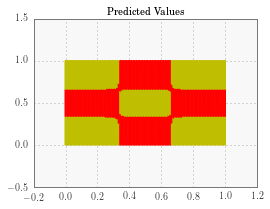

In [10]:
model.eval()
likelihood.eval()

f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
n = 100
test_x = Variable(torch.zeros(int(pow(n, 2)), 2))
for i in range(n):
    for j in range(n):
        test_x.data[i * n + j][0] = float(i) / (n-1)
        test_x.data[i * n + j][1] = float(j) / (n-1)
predictions = likelihood(model(test_x))

def ax_plot(ax, rand_var, title):
    pred_labels = rand_var.mean().ge(0.5).float().mul(2).sub(1).data.numpy()
    color = []
    for i in range(len(pred_labels)):
        if pred_labels[i] == 1:
            color.append('y')
        else:
            color.append('r')
    ax.scatter(test_x.data[:, 0].numpy(), test_x.data[:, 1].numpy(), color=color, s=1)
    ax.set_ylim([-0.5, 1.5])
    ax.set_title(title)

ax_plot(observed_ax, predictions, 'Predicted Values')